### Notebook for testing model functions with input data and examining output

To do, for PhD:
* Parameter file: tidy up. Provide recommended ranges and suggested default for each parameter, plus link to sources of info
* Tidy up GitHub repository: Separate from James' repository, delete old notebooks, write clear instructions for running model
* Tidy up code in main ipython notebook
* If have time, do big dictionary to change column headings for the output model results dataframes, so they're more friendly (e.g. including units), for terrestrial compartment & reach results

To do, longer term:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters? Can't re-calculate using v=Q/A, as it becomes circular when you try to work out T and V. Other options to reduce the number of parameters?
* What to do about quick flow? Should it vary by land use type? And if so, how? No quick flow apart from from agricultural land? Or quick flow from both, but more from agricultural land?
* Investigate whether having quick flow separated between agricultural and semi-natural land means that there's no longer the need for them to have different time constants
* TDP to SRP conversion. Best means of doing this? Do individually for agricultural and effluent inputs, and then combine?
* Option for dynamic effluent P inputs, i.e. option to read in a time series
* Option for dynamic terrestrial P inputs
* Option for dynamic groundwater TDP concentration, somehow linked to what's happening overhead

In [19]:
# Provide the full file path to the excel parameter file
# The file path should be encased within apostrophes, with the letter r before the first
# apostrophe (to indicate that the string should be read as is, without stripping out the back slashes)

# work laptop:
# params_fpath = r'C:\Users\lj40184\Documents\GitHub\enviro_mod_notes\notebooks\ModelInputs\parameters_v2.xlsx'
# work desktop:
params_fpath = r'D:\GitHub\enviro_mod_notes\notebooks\ModelInputs\parameters_v2.xlsx'

In [20]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, mpld3, seaborn as sn, os, matplotlib as mpl, csv
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
from matplotlib.ticker import MaxNLocator # for sorting out ticks
mpl.rcParams['pdf.fonttype'] = 42

sn.set_context('notebook') # change to 'notebook' if you want to haev larger font sizes
                        # (e.g. for viewing graphs here, or for saving for posters)
                        # Otherwise, 'paper'

In [21]:
# Unit conversions, to reduce mistakes due to typos throughout the rest of the code

# Throughout, A_catch has units of km2
def UC_Q(Q_mmd, A_catch):
    """Convert discharge from units of mm/day to m3/day"""
    Q_m3d = Q_mmd*1000*A_catch
    return Q_m3d

def UC_Qinv(Q_m3s, A_catch):
    """Convert discharge from units of m3/s to mm/day"""
    Q_mmd = Q_m3s * 86400/(1000*A_catch)
    return Q_mmd

def UC_C(C_kgmm, A_catch):
    """Convert concentration from units of kg/mm to mg/l
    Divide answer by 10**6 to convert from mg/mm to mg/l"""
    C_mgl = C_kgmm/A_catch
    return C_mgl

def UC_Cinv(C_mgl, A_catch):
    """Convert concentration from units of mg/l to kg/mm"""
    C_kgmm = C_mgl*A_catch
    return C_kgmm
    
def UC_V(V_mm, A_catch, outUnits):
    """Convert volume from mm to m^3 or to litres. outUnits 'm3' or 'l'"""
    factorDict = {'m3':10**3, 'l':10**6}
    V = V_mm * factorDict[outUnits] * A_catch
    return V

In [22]:
# READ IN INPUT DATA

# USER SET-UP PARAMETERS
p_SU = pd.read_excel(params_fpath,sheetname='Setup',index_col=0,parse_cols="A,C")
p_SU = p_SU['Value'] # Convert to a series

# Extract user set-up parameters for dynamic dict
# **dynamic terrestrial P inputs and effluent inputs not yet implemented**
dynamic_options = p_SU[['Dynamic_EPC0', 'Dynamic_effluent_inputs',
                  'Dynamic_terrestrialP_inputs','Dynamic_erodibility']]

# MODEL PARAMETERS

# Parameters that're constant over land use, sub-catchment or reach. Values in col 'Value'
p = pd.read_excel(params_fpath,sheetname='Constant',index_col=0,parse_cols="B,E")
p = p['Value'] # Convert to a series

# Land use parameters. Values in cols A,S,IG,NC
p_LU = pd.read_excel(params_fpath, sheetname='LU',index_col=0,parse_cols="B,E,F,G,H")

# Sub-catchment and reach parameters. Values in cols '1', '2',..
# Some fiddling required to parse the right number of columns, according to the number of SCs
p['SC_list'] = np.arange(1,p_SU.n_SC+1)
lastCol = chr(ord('E')+p_SU.n_SC-1) # Last column in excel sheet to be parsed
if p_SU.n_SC ==1:
    parse_cols_str = "B,E"
else:
    parse_cols_str = "B,E:%s" %lastCol
p_SC = pd.read_excel(params_fpath, sheetname='SC_reach',index_col=0, parse_cols=parse_cols_str)

# MET DATA
# Assume constant met data over the catchment. This could be amended in the future.
met_df = pd.read_csv(p_SU.metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
met_df = met_df.truncate(before=p_SU.st_dt, after=p_SU.end_dt)  # Truncate to the desired period

# OBSERVATIONS
# Read from excel files (one for each of Q and chem). Excel files should have one sheet per
# sub-catchment/reach, numbered 1, 2, etc. Obs for each reach are read into a dataframe.
# Each reach is stored as a separate df in obs_dict (key is the reach number, as an integer).
# Units of Q: m3/s, Units of chemistry: mg/l
Qobs_xl = pd.ExcelFile(p_SU.Qobsdata_fpath)
chemObs_xl = pd.ExcelFile(p_SU.chemObsData_fpath)
SC_with_Qobs = [int(x) for x in Qobs_xl.sheet_names]  # List of sub-catchments with Q data
SC_with_chemObs = [int(x) for x in chemObs_xl.sheet_names]  # List of sub-catchments with chemistry data
obs_dict = {}   # Key: sub-catchment number (1,2,...); only SCs with obs are included
                # Returns dataframe of observed data (if any)
for SC in p['SC_list']:  # Loop through all sub-catchments being simulated
    df_li = []  # List of Q and chem dataframes for the reach; may be empty or have up to 2 dfs
    if SC in SC_with_Qobs:  # Check whether the sub-catchment has discharge data
        Qobs_df = pd.read_excel(p_SU.Qobsdata_fpath, sheetname=str(SC), index_col=0,
                                parse_dates=True, dayfirst=True)
        Qobs_df = Qobs_df.truncate(before=p_SU.st_dt, after=p_SU.end_dt)
        df_li.append(Qobs_df)
    if SC in SC_with_chemObs:  # Check whether the sub-catchment has chemistry data
        chemObs_df = pd.read_excel(p_SU.chemObsData_fpath, sheetname=str(SC), index_col=0, 
                                   parse_dates=True, dayfirst=True)
        chemObs_df = chemObs_df.truncate(before=p_SU.st_dt, after=p_SU.end_dt)
        df_li.append(chemObs_df)
    # If this SC has observations, add it to the dictionary of observations (obs_dict)
    if df_li:  # If there's something in the list, this returns true; otherwise false
        obs_df = pd.concat(df_li, axis=1)  # If have both Q & chem data, combine into one df
        obs_dict[SC] = obs_df  # Add to dictionary

In [23]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba

# Future potential extensions:
# (1) Add options for how temperature is assumed to vary through the day, e.g. triangular or sinuosoidal
# variations to get a more accurate portrayal of the degree-days above the threshold.
# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store (mm/d)
    """
    
    # Precipitation falling as snow (mm/d, as water equivalents)
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]  # = total pptn if air T<0
    met_df['P_snow'].fillna(0, inplace=True)  # otherwise, =0
    
    # Precipitation falling as rain (mm/d)
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Potential daily snow melt (unlimited by snow pack depth) (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0 (i.e. only melt when T_air>0)

    # Snow pack depth (mm), as end of day depth = start of day depth + inputs - melt, where melt is
    # limited by the depth wherever necessary.
    met_df['D_snow_start'], met_df['D_snow_end'] = np.nan, np.nan # Set-up
    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 # Assign user-supplied starting depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start']) # Melt limited by depth
    met_df.ix[0,'D_snow_end'] = (met_df.ix[0,'D_snow_start']+
                                met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']) # Change over day
    # Calculate for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [24]:
def P_model_v2_beta3(met_df, p_LU, p_SC, p, dynamic_options, run_mode, inc_snowmelt, step_len=1):
    """
    Simple hydrology, sediment and phosphorus model, with processes varying by land use,
    sub-catchment and reach.
    
    Correction to Actual ET calculation (previously mu constant at 0.02, now varies with FC)

    Inputs:
        met_df         Dataframe containing columns 'P', the precipitation+snowmelt input to
                       the soil box, and 'PET' (units mm)

        p              Series of parameter values which don't vary by land use (index: param name)
        
        p_LU           Dataframe of parameter values which vary by land use
                       Index:   parameter name
                       Columns: 'A', 'S', 'IG' (agricultural, semi-natural, improved grassland)
                                IG only has values for parameter 'E_land' (soil erodibility), in
                                which case value in 'A' column is for arable land
        
        p_SC           Dataframe of parameter values which vary by sub-catchment or reach
                       Index:   parameter name
                       Columns: 1, 2, ...n sub-catchments

        dynamic_options   Series of options controlling whether inputs/variables are calculated
                       dynamically or kept constant.
                       Row indices: 'Dynamic_EPC0', 'Dynamic_erodibility', 'Dynamic_effluent_inputs',
                                    'Dynamic_terrestrialP_inputs'. 'y' or 'n'
                       **NB only the first 2 are implemented in the model at the moment**

        run_mode       'cal' or 'other'. Determines whether the soil sorption coefficient, Kf,
                       is calculated (calibration period) or read in from the parameter file
        
        inc_snowmelt   Convert input precipitation timeseries to rainfall and snowmelt using the
                       snow accumulation & melt function?

        step_len       Length of each step in the input dataset (days). Default=1

    Returns a three-element tuple (df, Kf):
    
    1)  df_TC_dict: A dictionary containing dataframes of results for the terrestrial compartment,
        with one dataframe per sub-catchment (key is the sub-catchment number as an integer).
        The dataframe has column headings:
        
        VsA:          Soil water volume, agricultural land (mm)
        VsS:          Soil water volume, semi-natural land (mm)
        QsA:          Soil water flow, agricultural land (mm/d)
        QsS:          Soil water flow, semi-natural land (mm/d)
        Vg:           Groundwater volume (mm)
        Qg:           Groundwater flow (mm/d)
        Qq:           Quick flow (mm/d)
        Mland_A:      Sediment mass delivered to the stream, arable land (kg/d),
        Mland_IG:     Sediment mass delivered to the stream, improved grassland (kg/d)
        Mland_S:      Sediment mass delivered to the stream, semi-natural land (kg/d)
        P_labile_A:   Labile soil P mass in agricultural soil (kg)
        P_labile_NC:  Labile soil P mass in newly-converted agricultural or semi-natural land (kg)
        EPC0_A_kgmm:  EPC0 in agricultural soil (kg/mm)
        EPC0_NC_kgmm: EPC0 in newly-converted agricultural or semi-natural soil (kg/mm)       
        TDPs_A:       Soil water TDP mass, agricultural land (kg)
        TDPs_NC:      Soil water TDP mass, newly-converted agricultural or semi-natural land (kg)

    2)  df_R_dict: A dictionary containing dataframes of results for the stream reach, with one
        dataframe per sub-catchment (dictionary key is the sub-catchment number as an integer).
        Dataframe column headings:
        
        Vr:   Reach volume (mm)
        Qr:   Mean daily discharge from the reach (mm/d)
        Msus: Daily flux of suspended sediment from the reach (kg/day)
        TDPr: Daily flux of TDP from the reach (kg/day)
        PPr:  Daily flux of PP from the reach (kg/day)
        
        Note that instantaneous fluxes of in-stream Q and masses of SS, PP and TDP are also
        calculated by the model, and could be saved to this output dataframe if there was a need,
        rather than these daily fluxes. However, daily fluxes are used for calculating mean
        volume-weighted concentrations.

    3)  Kf: the soil adsorption coefficient (units mm/kg Soil). From (mgP/kgSoil)(mm/kgP).
        Multiply by: 10^-6 for (mm/kgSoil), by A_catch*10^6 for (l/kgSoil).
    
    4) ODE_output_dict: Full output from the ODE solver, providing technical details of
                        solving the ODE system.
    """
    
    #########################################################################################
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """
        Define ODE system
        Inputs:
            y: list of variables expressed as dy/dx. y is determined for the end of the time step
            t: array of time points of interest
            params: tuple of input values & model parameter values
        """
        
        # Unpack params. Params that vary by LU are series, with indices ['A','S','IG'],
        # LU-varying params: T_s,P_netInput,EPC0,Mland_i
        (P, E, mu, Qq_i, Qr_US_i, Mland_i, Msus_US_i, TDPr_US_i, PPr_US_i,
         f_A, f_Ar, f_IG, f_S, f_NC_A, f_NC_Ar, f_NC_IG, f_NC_S, NC_type,
         f_quick, alpha, beta, T_s, T_g, fc, L_reach, S_reach, A_catch,
         a_Q, b_Q, E_Q, k_EQ, P_netInput, EPC0_A, EPC0_NC, Kf, Msoil, TDPeff,
         TDPg, E_PP, P_inactive, bedSed_Pconc) = ode_params
        
        # Unpack initial conditions for this time step
        # Hydrology
        VsA_i = y[0] # Agricultural soil water volume (mm)
        QsA_i = y[1] # Agricultural soil water flow (mm/day)
        VsS_i = y[2] # Semi-natural soil water volume (mm)
        QsS_i = y[3] # Semi-natural soil water flow (mm/day)
        Vg_i = y[4]  # Groundwater volume (mm)
        Qg_i = y[5]  # Groundwater discharge (mm/day)
        Vr_i = y[6]  # Reach volume (mm)
        Qr_i = y[7]  # Instantaneous reach discharge (mm/day)
        #(Qr_av_i would be y[8] here, but it's 0 at the start of every time step)
        # Sediment
        Msus_i = y[9]  # Mass of suspended sediment in the stream reach (kg)
        # (Msus_out_i would be y[10], but it's 0 at the start of every time step)
        # Phosphorus
        PlabA_i = y[11] # Mass of labile P in agricultural soil (kg)
        PlabNC_i = y[12] # Mass of labile P in newly converted land class (kg)
        TDPsA_i = y[13] # Mass of TDP in agricultural soil water (kg)
        TDPsNC_i = y[14] # Mass of TDP in newly converted land class (kg)
        TDPr_i = y[15] # Mass of total dissolved P in stream reach (kg)
        # (TDPr_out_i would be y[16], but it's 0 at the start of every time step)
        PPr_i = y[17]  # Mass of particulate P in stream reach (kg)
        # (PPr_out_i would be y[18], but it's 0 at the start of every time step)
        # Soil water vol & flow for newly converted land class
        if NC_type == 'A':  # If semi-natural converted to arable, assume has arable hydrol
            VsNC_i = VsA_i
            QsNC_i = QsA_i
        else:
            VsNC_i = VsS_i  # If arable converted to SN, assume has semi-natural hydrol
            QsNC_i = QsS_i
    
        # HYDROLOGY
        
        # Soil hydrology equations (units mm or mm/day): Agricultural land
        dQsA_dV = ((((VsA_i - fc)*np.exp(fc - VsA_i))/(T_s['A']*((np.exp(fc-VsA_i) + 1)**2)))
                    +(1/(T_s['A']*(np.exp(fc-VsA_i) + 1))))
        dVsA_dt = P*(1-f_quick) - alpha*E*(1 - np.exp(-mu*VsA_i)) - QsA_i  # mu a function of fc
        dQsA_dt = dQsA_dV*dVsA_dt
        
        # Soil hydrology equations (units mm or mm/day): Semi-natural/other land
        dQsS_dV = ((((VsS_i - fc)*np.exp(fc - VsS_i))/(T_s['S']*((np.exp(fc-VsS_i) + 1)**2)))
                    +(1/(T_s['S']*(np.exp(fc-VsS_i) + 1))))
        dVsS_dt = P*(1-f_quick) - alpha*E*(1 - np.exp(-mu*VsS_i)) - QsS_i
        dQsS_dt = dQsS_dV*dVsS_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i)/T_g
        dVg_dt = beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i
        
        # Instream equations (units mm or mm/day)
        dQr_dt = ((Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i + Qr_US_i - Qr_i) # Fluxes (mm/d)
                  *a_Q*(Qr_i**b_Q)*(8.64*10**4)/((1-b_Q)*(L_reach)))
                  # 2nd row is U/L=1/T. Units:(m/s)(s/d)(1/m)
        dVr_dt = Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i + Qr_US_i - Qr_i
        dQr_av_dt = Qr_i  # Daily mean flow
        
        # SEDIMENT
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = (f_Ar*Mland_i['A'] + f_IG*Mland_i['IG'] + f_S* Mland_i['S']  # From land (kg/day)
                   + E_Q*S_reach*(Qr_i**k_EQ)             # Entrainment from the stream bed (kg/d)
                   + Msus_US_i                            # Inputs from upstream
                   - (Msus_i/Vr_i)*Qr_i)                  # Outflow from the reach;(kg/mm)*(mm/day)
        
        dMsus_out_dt = Qr_i*Msus_i/Vr_i  # Daily flux of SS
        
        # PHOSPHORUS
        
        # Agricultural soil labile P mass (kg). Assume semi-natural land has no labile soil P
        dPlabA_dt = Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)  # Net sorption
        # dPlabA_dt = (PlabA_i/EPC0_A)*((TDPsA_i/VsA_i)-EPC0_A) # Alternative sorpn formulation
        
        # Newly-conveted soil labile P mass (kg)
        dPlabNC_dt = Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)
        
        # Change in dissolved P mass in agricultural soil water (kg/day)
        # Assume semi-natural land has no dissolved soil water P
        dTDPsA_dt = ((P_netInput['A']*100*A_catch/365)  # Net inputs (fert+manure-uptake) (kg/ha/yr)
                   - Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)  # Net sorpn (kg/day) (could be alt above)
                   - (QsA_i*TDPsA_i/VsA_i)              # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsA_i/VsA_i))              # Outflow via quick flow (kg/day)
        
        # And in newly converted land class soil water
        dTDPsNC_dt = ((P_netInput['NC']*100*A_catch/365)    # Net inputs (kg/ha/yr)
                   - Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)   # Net sorpn (kg/day)
                   - (QsNC_i*TDPsNC_i/VsNC_i)               # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsNC_i/VsNC_i))                # Outflow via quick flow (kg/day)
        
        # Change in in-stream TDP mass (kg/d)
        # Semi-natural inputs not specified as assume 0 for soil water & quick flow
        dTDPr_dt = ((1-beta)*f_A*QsA_i*(TDPsA_i/VsA_i)  # Soil input, old agri. Units:(mm/d)(kg/mm)
                   + (1-beta)*f_NC_A*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil input, new agri land
                   + (1-beta)*f_NC_S*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil input, new SN land
                   + f_A*Qq_i*(TDPsA_i/VsA_i)           # Quick input, old agri. Units:(mm/d)(kg/mm)
                   + f_NC_A*Qq_i*(TDPsNC_i/VsNC_i)      # Quick input, newly-converted agri
                   + f_NC_S*Qq_i*(TDPsNC_i/VsNC_i)      # Quick inputs, newly-converted SN
                   + Qg_i*UC_Cinv(TDPg,A_catch)         # Groundwater input. Units: (mm/d)(kg/mm)
                   + TDPeff                             # Effluent input (kg/day)
                   + TDPr_US_i                          # Inputs from upstream 
                   - Qr_i*(TDPr_i/Vr_i))                # Reach outflow. Units: (mm/d)(kg/mm)
        
        dTDPr_out_dt = Qr_i*TDPr_i/Vr_i  # Daily TDP flux out of reach. Units: (mm/d)(kg/mm)=kg/d
        
        # Change in in-stream PP mass (kg/d)
        dPPr_dt = (E_PP *
                   (f_Ar*Mland_i['A']*(PlabA_i+P_inactive)/Msoil         # Old arable land
                   + f_IG*Mland_i['IG']*(PlabA_i+P_inactive)/Msoil       # Old improved grassland
                   + f_S*Mland_i['S']*P_inactive/Msoil)                  # Semi-natural land
                   + f_NC_Ar*Mland_i['A']*(PlabNC_i+P_inactive)/Msoil    # Newly-converted arable
                   + f_NC_IG*Mland_i['IG']*(PlabNC_i+P_inactive)/Msoil   # Newly-converted IG
                   + f_NC_S*Mland_i['S']*(PlabNC_i+P_inactive)/Msoil     # New semi-natural
                   + (E_Q*S_reach*(Qr_i**k_EQ))*bedSed_Pconc        # Entrained or eroded
                   + PPr_US_i                                            # Inputs from upstream 
                   - Qr_i*(PPr_i/Vr_i))                               # Reach outflow (mm/d)(kg/mm)
        
        dPPr_out_dt = Qr_i*PPr_i/Vr_i  # Daily mean flux
        
        # Add results of equations to an array
        res = np.array([dVsA_dt, dQsA_dt, dVsS_dt, dQsS_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt,
                        dQr_av_dt, dMsus_dt, dMsus_out_dt, dPlabA_dt, dPlabNC_dt, dTDPsA_dt,
                        dTDPsNC_dt, dTDPr_dt, dTDPr_out_dt, dPPr_dt, dPPr_out_dt])
        return res
    
    #########################################################################################
    # Define other useful functions
    def lin_interp(x, x0, x1, y0, y1):
        y = y0 + (y1-y0)*(x-x0)/(x1-x0)
        return y
    
    ##########################################################################################
    # PROCESS INPUT PARAMETERS
    # All params; index = param names, values in cols

    # LAND USE PARAMS
    # Add empty rows to land use param dataframe, to be populated later in model
    # (4 classes: 'A','S','NC','IG')
    p_LU.ix['EPC0_0',:] = 4*[np.NaN]  # Initial EPC0 (kg/mm)
    p_LU.ix['Plab0',:] = 4*[np.NaN]   # Initial labile P (kg)
    p_LU.ix['TDPs0',:] = 4*[np.NaN]   # Initial soil water TDP mass (kg)

    # SUB-CATCHMENT/REACH PARAMS
    # Calculate fraction of total area as intensive agricultural land
    p_SC.loc['f_A'] = p_SC.loc['f_IG']+p_SC.loc['f_Ar']
    p_SC.loc['f_NC_A'] = p_SC.loc['f_NC_Ar'] + p_SC.loc['f_NC_IG']

    # Check that land use proportions add to 1 in all sub-catchments; raise an error if not
    for SC in p['SC_list']:
        if (p_SC.loc['f_A',SC]+p_SC.loc['f_S',SC]
            +p_SC.loc['f_NC_A',SC]+p_SC.loc['f_NC_S',SC]) != 1:
            raise ValueError('Land use proportions do not add to 1 in SC %s' %SC)

        # Determine whether newly-converted land is agri or SN (raise error if both)
        if p_SC.loc['f_NC_A',SC] > 0:
            if p_SC.loc['f_NC_S',SC] > 0: 
                raise ValueError("SC %s has 2 kinds of newly-converted land;\n\
                only one permitted (SN or agri)" %SC)
            else:
                NC_type = 'A'
        elif p_SC.loc['f_NC_S',SC]>0:
            NC_type = 'S'
        else:
            NC_type = 'None'
        p_SC.loc['NC_type',SC] = NC_type
    
    ##########################################################################################
    # If desired, run snow module
    if inc_snowmelt == 'y':
        met_df = hydrol_inputs(p['D_snow_0'], p['f_DDSM'], met_df)
    else:
        met_df.rename(columns={'Pptn':'P'}, inplace=True)
        
    #########################################################################################
    # SETUP ADMIN FOR LOOPING OVER TIME STEPS AND SUB-CATCHMENTS
    
    # Dictionary to store results in for different sub-catchments
    df_TC_dict = {} # Key: SC number (int); returns df of terrestrial compartment results
    df_R_dict = {}  # Key: SC number (int); returns df of in-stream (reach) results
    
    # Time points to evaluate ODEs at (we're only interested in the start and end of each step)
    ti = [0, step_len]
    
    # Calculate the value of the shape parameter mu, in the exponential relating actual and
    # potential ET
    mu = -np.log(0.01)/p['fc']
    
    # Dictionary of parameters defining the dynamic crop cover-related erodibility (for the
    # M_land calculation)
    Erisk_dict = {}  # Key: 'spr' or 'aut'. Returns series with indices 'start','end','mid
    E_risk_period = 60.0
    for season in ['spr','aut']:
        d_dict = {'start':p['d_maxE_%s' %season]-E_risk_period/2.,
                  'end':p['d_maxE_%s' %season]+E_risk_period/2.,
                  'mid':p['d_maxE_%s' %season]}
        d_S = pd.Series(d_dict)
        Erisk_dict[season] = d_S
        
    #-----------------------------------------------------------------------------------------
    # INITIAL CONDITIONS AND DERIVED PARAMETERS THAT DON'T VARY BY SUB-CATCHMENT
    # Unpack user-supplied initial conditions, calculate any others, convert units
    
    # 1) Terrestrial - constant over LU and SC
    # Hydrol
    VsA0 = p['fc']   # Initial soil volume (mm). Assume it's at field capacity.
    VsS0 = VsA0      # Initial soil vol, semi-natural land (mm). Assumed same as agricultural!!
    Qg0 = p['beta']*UC_Qinv(p['Qr0_init'], p_SC.ix['A_catch',SC]) # Initial groundwater flow (mm/d)

    #-----------------------------------------------------------------------------------------
    # START LOOP OVER SUB-CATCHMENTS
    for SC in p['SC_list']:
        
        # INITIAL CONDITIONS THAT VARY BY SUB-CATCHMENT
    
        # Soil mass and inactive soil P (kg)
        # Assume inactive soil P is equivalent to semi-natural total soil P for all LU classes
        Msoil = p['Msoil_m2']*10**6*p_SC.ix['A_catch',SC] # Soil mass (kg): (kgSoil/m2)(m2/km2)km2
        P_inactive = 10**-6*p_LU['S']['SoilPconc']*Msoil

        # 2) Terrestrial - varying by land use and by sub-catchment
        for LU in ['A','S']:
            # Convert units of EPC0 from mg/l to kg/mm to give initial EPC0
            p_LU.ix['EPC0_0',LU] = UC_Cinv(p_LU[LU]['EPC0_init_mgl'], p_SC.ix['A_catch',SC])
            ### CHECK units here! Should same mg/l conc give diff kg/mm conc in diff SCs?????
            
            # Initial labile P. Units: (kgP/mgP)(mgP/kgSoil)kgSoil. Assume Plab0=0 for semi-natural
            p_LU.ix['Plab0',LU] = 10**-6*(p_LU[LU]['SoilPconc']-p_LU['S']['SoilPconc']) * Msoil
            # Initial soil water TDP mass (kg); Units: (kg/mm)*mm
            if LU == 'A':
                p_LU.ix['TDPs0',LU] = p_LU[LU]['EPC0_0']*VsA0
            else:
                p_LU.ix['TDPs0',LU] = 0
                        
        # Set initial agricultural labile P and soil TDP masses as variables to be updated during
        # looping (assume semi-natural remain at 0 for both)
        Plab0_A, TDPs0_A = p_LU.ix['Plab0','A'], p_LU.ix['TDPs0','A']
        # Initial labile P and soil TDP mass on newly converted land use class
        if p_SC.ix['NC_type',SC]=='S':
            Plab0_NC = Plab0_A  # New class is SN, from arable, therefore start with arable labile P
            TDPs0_NC = TDPs0_A
        else:
            Plab0_NC = 0.0      # New class is arable, from SN, therefore start with no labile P
            TDPs0_NC = p_LU.ix['TDPs0','S']

        # Set the value for Kf, the adsorption coefficient (mm/kg soil)
        if run_mode == 'cal': # If the calibration period, calculate.
            # Assume SN has EPC0=0, PlabConc =0. Units: (kg/mg)(mg/kgSoil)(mm/kg)
            Kf = 10**-6*(p_LU['A']['SoilPconc']-p_LU['S']['SoilPconc'])/p_LU['A']['EPC0_0']  
        else:  # If not the calibration period, read Kf in from the series of param values
            Kf = p['Kf']

        # 3) In-stream initial conditions (all reaches the same for chem)
        TDPr0, PPr0, Msus0 = 0.0, 0.0, 0.0  # Initial TDP, PP & SS masses (kg; assume all equal 0.0)
        # Initial in-stream flow
        if SC == 1:
            # Convert units of initial reach Q from m3/s to mm/day
            Qr0 = UC_Qinv(p['Qr0_init'], p_SC.ix['A_catch',SC])
        else:        # Outflow from the reach upstream from the first time step
            Qr0 = df_R_dict[SC-1].ix[0,'Qr']  # N.B. 'Qr' here is Qr_av, the daily mean flow
        
        # ADMIN
    
        # Dictionary of slopes for different land use classes in the sub-catchment:
        slope_dict = {'A':p_SC.ix['S_Ar',SC], 'IG':p_SC.ix['S_IG',SC], 'S':p_SC.ix['S_SN',SC]}
        
        # Arrays of land cover fractions and erodibility parameters, for use in the bed sed average
        # P content calculation
        f_LUs = np.array([p_SC.ix['f_Ar',SC],p_SC.ix['f_IG',SC],p_SC.ix['f_S',SC],
                         p_SC.ix['f_NC_Ar',SC],p_SC.ix['f_NC_IG',SC],p_SC.ix['f_NC_S',SC]])
        C_covs = np.array(2*[p_LU.ix['C_cover','A'],p_LU.ix['C_cover','IG'],p_LU.ix['C_cover','S']])
        C_Ms = 1-np.array(2*[p_LU.ix['C_measures','A'],p_LU.ix['C_measures','IG'],p_LU.ix['C_measures','S']])
              
        # Lists to store output
        output_ODEs = []    # From ode_f function
        output_nonODE = []  # Will include: Qq, Mland, Qr_US (latter for checking only)        
        
        #-------------------------------------------------------------------------------------
        # START LOOP OVER MET DATA
        for idx in range(len(met_df)):

            # Get precipitation and evapotranspiration for this day
            P = met_df.ix[idx, 'P']
            E = met_df.ix[idx, 'PET']

            # Calculate infiltration excess (mm/(day * catchment area))
            Qq_i = p['f_quick']*P
            
            # Inputs to reach from up-stream reaches
            if SC == 1:
                # For the top reach, set the input from upstream reaches to 0
                Qr_US_i, Msus_US_i, TDPr_US_i, PPr_US_i = 0.0, 0.0, 0.0, 0.0
            else:
                # Below reach 1, the upstream input is the daily mean flux from up-stream for the
                # current day
                Qr_US_i = df_R_dict[SC-1].ix[idx,'Qr']
                Msus_US_i = df_R_dict [SC-1].ix[idx, 'Msus']
                TDPr_US_i = df_R_dict [SC-1].ix[idx, 'TDPr']
                PPr_US_i = df_R_dict [SC-1].ix[idx, 'PPr']

            # Calculate delivery of sediment from the land to the stream (kg/day). NB this flux
            # assumes the land use covers the whole catchment. Divide by area to get areal flux
            Mland_i = pd.Series(3*[np.NaN],['A','S','IG']) # Empty series to store results in later
            dayNo = met_df.index[idx].dayofyear  # Day of the year (1 to 365)
            for LU in ['A','S','IG']:
                if LU == 'A':
                    # If arable land, work out a dynamic crop cover factor, to account for the variation
                    # in erodibility through the year due to harvesting and planting practices.
                    if dynamic_options['Dynamic_erodibility'] == 'y':
                        
                        # Using a sine wave to simulate the annual change in erodibility
#                         C_spr_t = p_LU[LU]['C_cover']*(np.cos((2*np.pi/365)*(dayNo-p['d_maxE_spr']))+1)
#                         C_aut_t = p_LU[LU]['C_cover']*(np.cos((2*np.pi/365)*(dayNo-p['d_maxE_aut']))+1)
#                         C_cover = (p_SC.ix['f_spr',SC]*C_spr_t +(1-p_SC.ix['f_spr',SC])*C_aut_t)
                        
                        # Using a triangular wave
                        C_cov_dict = {} # Dict for storing spring & autumn results in
                        for s in ['spr','aut']:  # Loop through seasons
                            d = Erisk_dict # Defined above; dict defining high erosion risk period
                            d_start, d_end, d_mid = d[s]['start'], d[s]['end'], d[s]['mid']
                            if dayNo in np.arange(d_start, d_end):
                                if dayNo < d_mid: # If within high risk period, before mid-point
                                    C_season = lin_interp(dayNo, x0=d_start, x1=d_mid,
                                                     y0=p_LU[LU]['C_cover'], y1=1.0)
                                else: # If in high risk period, after mid-point
                                    C_season = lin_interp(dayNo, x0=d_mid, x1=d_end,
                                                     y0=1.0, y1=p_LU[LU]['C_cover'])
                            else: # Otherwise, outside high risk period
                                C_season = (p_LU[LU]['C_cover']-(E_risk_period*(1-p_LU[LU]['C_cover'])
                                           /(2*(365-E_risk_period))))
                            C_cov_dict[s] = C_season
                        # Average the dynamic factor over spring and autumn-sown crops
                        C_cover = (p_SC.ix['f_spr',SC]*C_cov_dict['spr']
                                   + (1-p_SC.ix['f_spr',SC])*C_cov_dict['aut'])  
                        
                    else:  # If not calculating a dynamic crop cover, then just assign user parameter
                        C_cover = p_LU[LU]['C_cover']
                        
                    C_cover_A = C_cover  # Store this for arable land, for checking
                
                else:  # For non-arable LU, the cover factor is always constant throughout the year
                    C_cover = p_LU[LU]['C_cover']
                
                # Sediment yield per land use class (kg/d). See documentation for rationale/source
                Mland_i[LU] = 10**5*(p['E_land']*(Qq_i**p['k_Eland'])
                              *slope_dict[LU]
                              *p_SC.ix['K_erosion',SC]
                              *C_cover
                              *(1-p_LU[LU]['C_measures']))
            
            # Calculate the P content of bed sediment, for use in the entrainment calculation. This is
            # weighted by both the land use areas and the difference in erodibility (and therefore sediment
            # yield) between land cover classes. Result checked manually and good.
            # First, make an array of labile P content, to correspond to arrays of LU cover, & erodibility
            # (defined above). Order of elements: Ar, IG, S, NC_Ar, NC_Ig, NC_SN
            Plabs = np.array([Plab0_A, Plab0_A, 0.0, Plab0_NC, Plab0_NC, Plab0_NC])
            TPs = Plabs + P_inactive # Array of total P content for the 6 LUCs
            bedSed_Pconc = p['E_PP']*(1/np.sum(f_LUs*C_covs*C_Ms))*np.sum(f_LUs*C_covs*C_Ms*TPs)/Msoil

            # Calculate dynamic EPC0 as a function of labile P mass
            if dynamic_options['Dynamic_EPC0'] == 'y':
                EPC0_A_i = Plab0_A/(Kf*Msoil) # Agricultural EPC0; equals EPC0_0 on the 1st timestep
                EPC0_NC_i = Plab0_NC/(Kf*Msoil) # EPC0 on newly-converted land
            # Or, have a constant EPC0 throughout the model run
            else:
                EPC0_A_i = p_LU['A']['EPC0_0']
                if p_SC.ix['NC_type',SC] == 'S': # (little point in a new class with constant EPC0)
                    EPC0_NC_i = p_LU['A']['EPC0_0']  # New semi-natural land has agricultural EPC0
                else:
                    EPC0_NC_i = p_LU['S']['EPC0_0']  # New agricultural has SN EPC0

            # Append to non-ODE results
            output_nonODE_i = [Qq_i, Mland_i['A'],Mland_i['IG'],Mland_i['S'],
                               EPC0_A_i, EPC0_NC_i,C_cover_A ]
            output_nonODE.append(output_nonODE_i)

            # Calculate additional initial conditions from user-input values/ODE solver output
            # Soil flow, agricultural (mm/d)
            QsA0 = (VsA0 - p['fc'])/(p_LU['A']['T_s']*(1 + np.exp(p['fc'] - VsA0)))
            # Soil flow, semi-natural (mm/d)
            QsS0 = (VsS0 - p['fc'])/(p_LU['S']['T_s']*(1 + np.exp(p['fc'] - VsS0)))
            Vg0 = Qg0 *p['T_g']     # Groundwater vol (mm)
            Tr0 = ((p_SC.ix['L_reach',SC])/
                   (p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**4))) # Reach time constant (days); T=L/aQ^b
            Vr0 = Qr0*Tr0 # Reach volume (V=QT) (mm)

            # Vector of initial conditions for start of time step (assume 0 for initial Qr_av,
            # Msus_out, TDPr_out and PPr_out, the mass or vol of water lost per time step
            y0 = [VsA0, QsA0, VsS0, QsS0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0, 0.0, Plab0_A, Plab0_NC,
                  TDPs0_A, TDPs0_NC, TDPr0, 0.0, PPr0, 0.0]

            # Today's rainfall, ET & model parameters for input to solver. NB the order must be the
            # same as the order in which they are unpacked within the odeint function
            ode_params = [P, E, mu, Qq_i, Qr_US_i, Mland_i, Msus_US_i, TDPr_US_i, PPr_US_i,
                          p_SC.ix['f_A',SC],p_SC.ix['f_Ar',SC],p_SC.ix['f_IG',SC],p_SC.ix['f_S',SC],
                          p_SC.ix['f_NC_A',SC],p_SC.ix['f_NC_Ar',SC],p_SC.ix['f_NC_IG',SC],
                          p_SC.ix['f_NC_S',SC],p_SC.ix['NC_type',SC],
                          p['f_quick'],p['alpha'], p['beta'],
                          p_LU.ix['T_s'], p['T_g'], p['fc'],
                          p_SC.ix['L_reach',SC], p_SC.ix['S_reach',SC], p_SC.ix['A_catch',SC],
                          p['a_Q'], p['b_Q'], p['E_Q'], p['k_EQ'],
                          p_LU.ix['P_netInput'], EPC0_A_i, EPC0_NC_i, Kf, Msoil,
                          p_SC.ix['TDPeff',SC], p['TDPg'], p['E_PP'], P_inactive, bedSed_Pconc]

            # Solve ODEs
            # N.B. rtol is part of the error tolerance. Default is ~1e-8, but reducing it removes the
            # risk of the solver exiting before finding a solution due to reaching max number of steps
            # (in which case can get odd output). Also speeds up runtime.
            # This issue can also be circumvented by increasing the max. number of steps to 5000.
            y, output_dict = odeint(ode_f, y0, ti, args=(ode_params,),full_output=1, rtol=0.01, mxstep=5000)

            # Extract values for the end of the step
            res = y[1]
            res[res<0] = 0 # Numerical errors may result in very tiny values <0; set these back to 0
            output_ODEs.append(res)

            # Update initial conditions for next step (for Vs, Qg0, Qr0, Msus0, Plab0, TDPs0)
            VsA0 = res[0]  # QsA0 would be res[1]
            VsS0 = res[2]  # QsS0 would be res[3], Vg0 would be res[4] (but calculate from Qg0)
            # Re-set groundwater to user-supplied minimum flow at start of each time step. Non-ideal
            # solution to the problem or maintaining stream flow during baseflow conditions.
            if p['Qg_min'] > res[5]:
                Qg0 = p['Qg_min']
            else:
                Qg0 = res[5]
            # Vr0 would be res[6], but calculate from Qr0 instead
            Qr0 = res[7]       # Qr_av_0 would be res[8], but it's always 0
            Msus0 = res[9]     # Msus_out_0 would be res[10]
            Plab0_A = res[11]
            Plab0_NC = res[12]
            TDPs0_A = res[13]
            TDPs0_NC = res[14]
            TDPr0 = res[15]    # TDPr_out_0 would be res[16], but it's always 0
            PPr0 = res[17]     # TDPr_out_0 would be res[18], but it's always 0

            # END LOOP OVER MET DATA
        #-------------------------------------------------------------------------------------
    
        # Build a dataframe of ODE results
        df_ODE = pd.DataFrame(data=np.vstack(output_ODEs),
                           columns=['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'Vr', 'Qr_instant', 'Qr',
                           'Msus_instant', 'Msus', 'P_labile_A', 'P_labile_NC', 'TDPs_A', 'TDPs_NC',
                           'TDPr_instant', 'TDPr', 'PPr_instant', 'PPr'], index=met_df.index)

        # Dataframe of non ODE results
        df_nonODE = pd.DataFrame(data=np.vstack(output_nonODE),
                                 columns=['Qq','Mland_A','Mland_IG','Mland_S',
                                'EPC0_A_kgmm', 'EPC0_NC_kgmm', 'C_cover_A'], index=met_df.index)        
    
        # ####################################################################################
        # POST-PROCESSING OF MODEL OUTPUT

        # 1) Terrestrial compartment
        
        # Rearrange ODE and non-ODE result dataframes into results dataframes for the terrestrial
        # compartment (df_TC) and the stream reach (df_R)
        df_TC = pd.concat([df_ODE[['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'P_labile_A',
                                  'P_labile_NC','TDPs_A', 'TDPs_NC']],df_nonODE], axis=1)

        # Calculate simulated concentrations and add to results
        df_TC['TDPs_A_mgl'] = UC_C(df_TC['TDPs_A']/df_TC['VsA'], p_SC.ix['A_catch',SC])
        df_TC['EPC0_A_mgl'] = UC_C(df_TC['EPC0_A_kgmm'], p_SC.ix['A_catch',SC])
        df_TC['Plabile_A_mgkg'] = (10**6*df_TC['P_labile_A']/(p['Msoil_m2']
                                    * 10**6 *p_SC.ix['A_catch',SC]))
        # If have some newly-converted land, add results to dataframe
        if p_SC.ix['NC_type',SC] != 'None':
            if p_SC.ix['NC_type',SC] == 'A':  # If SN converted to arable, assume arable hydrol
                df_TC['VsNC'] = df_TC['VsA']
                df_TC['QsNC'] = df_TC['QsA']
            else:  # If arable converted to SN, assume instantly has semi-natural hydrol
                df_TC['VsNC'] = df_TC['VsS']
                df_TC['QsNC'] = df_TC['QsS']
            df_TC['TDPs_NC_mgl'] = UC_C(df_TC['TDPs_NC']/df_TC['VsNC'], p_SC.ix['A_catch',SC])
            df_TC['Plabile_NC_mgkg'] = (10**6*df_TC['P_labile_NC']
                                                /(p['Msoil_m2']*10**6 *p_SC.ix['A_catch',SC]))
        # Add snow depth
        df_TC['D_snow'] = met_df['D_snow_end']

        # 2) In-stream
        # NB masses of SS and P are all total fluxes for the day, and Q is the daily mean flow
        df_R = df_ODE.drop(['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'Qr_instant',
                           'Msus_instant','P_labile_A', 'P_labile_NC', 'TDPs_A', 'TDPs_NC',
                           'TDPr_instant', 'PPr_instant'], axis=1)

        # Calculate concentrations (mg/l); generally from (kg/d)(d/mm)
        df_R['SS_mgl'] = UC_C(df_R['Msus']/df_R['Qr'],p_SC.ix['A_catch',SC])
        df_R['TDP_mgl'] = UC_C(df_R['TDPr']/df_R['Qr'],p_SC.ix['A_catch',SC])
        df_R['PP_mgl'] = UC_C(df_R['PPr']/df_R['Qr'],p_SC.ix['A_catch',SC])
        df_R['TP_mgl'] = df_R['TDP_mgl'] + df_R['PP_mgl']
        # Convert flow units from mm/d to m3/s
        df_R['Sim_Q_cumecs'] = df_R['Qr']*p_SC.ix['A_catch',SC]*1000/86400
        
        # ------------------------------------------------------------------------------------
        # Sort indices & add to dictionaries; key = sub-catchment/reach number
        df_TC = df_TC.sort_index(axis=1)
        df_R = df_R.sort_index(axis=1)
        df_TC_dict[SC] = df_TC
        df_R_dict[SC] = df_R
        
        # END LOOP OVER SUB-CATCHMENTS
        #-------------------------------------------------------------------------------------

    return (df_TC_dict, df_R_dict, Kf, output_dict)  # NB Kf is returned for the last SC only

In [25]:
# RUN MODEL      
# If calibrating, Kf parameter (soil sorption coefficient) should be saved & used for setting for the
# validation/scenarios
df_TC_dict, df_R_dict, Kf, ode_output_dict = P_model_v2_beta3(met_df=met_df, p_LU=p_LU, p_SC=p_SC, p=p,
                                             dynamic_options=dynamic_options, run_mode=p_SU.run_mode,
                                             inc_snowmelt=p_SU.inc_snowmelt)

In [26]:
# SAVE TERRESTRIAL AND INSTREAM RESULTS TO CSV
if p_SU.save_output_csvs == 'y':
    for SC in df_R_dict.keys():
        df_TC_dict[SC].to_csv(os.path.join(p_SU.output_fpath,"Results_TC_SC%s.csv"%SC))
        df_R_dict[SC].to_csv(os.path.join(p_SU.output_fpath,"Instream_results_Reach%s.csv"%SC))

In [27]:
# SET UP FOR PLOTTING AND STATS

# General plotting params
w = 7.5     # figure width, in inches; fits with elsevier journals
h = 1 # subplot height, inches
max_yticks = 5

# Dictionary for re-naming ODE-output dataframe columns to match columns in obs dataframe
# (used in stats calc as well as in in-stream plot)
rename_dict = {'SS_mgl':'SS','TDP_mgl':'TDP','PP_mgl':'PP','TP_mgl':'TP','Sim_Q_cumecs':'Q'}

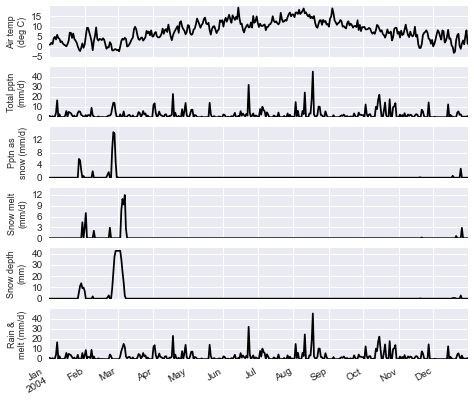

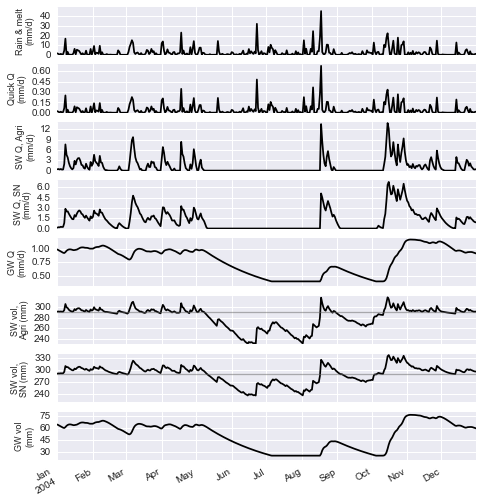

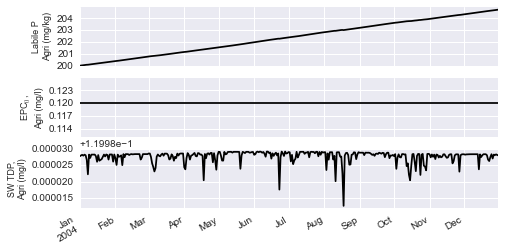

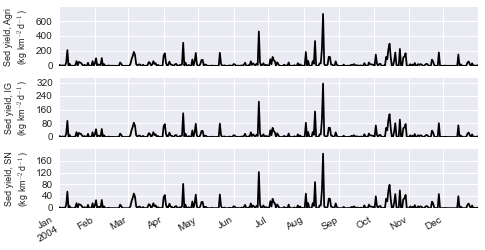

In [28]:
# PLOT MET DATA AND RESULTS OF SNOW MODULE

met_ylab_d = {'T_air':'Air temp\n(deg C)','PET':'PET (mm/d)', 'Pptn':'Total pptn\n(mm/d)',
             'P_snow':'Pptn as\nsnow (mm/d)', 'P_rain':'Pptn as\nrain (mm/d)',
             'P_melt':'Snow melt\n(mm/d)', 'D_snow_end':'Snow depth\n(mm)','P':'Rain &\nmelt (mm/d)' }

if p_SU.inc_snowmelt == 'y':
    met_plotVars = ['T_air','Pptn','P_snow','P_melt','D_snow_end','P']
    # PLOT
    met_df_forPlot = met_df[met_plotVars]
    fig_snow_axes = met_df_forPlot.plot(subplots=True,figsize=(w,len(met_plotVars)*h+1),
                                        legend=False)
    # Tidy plot & save
    for i, ax in enumerate(fig_snow_axes):
        fig_snow_axes[i].set_ylabel(met_ylab_d[met_plotVars[i]], fontsize=9)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_yticks, prune='upper'))
        plt.xlabel("")
    fname_snow = os.path.join(p_SU.output_fpath, "Fig_snow_results.%s" %p_SU.output_figtype)
    if p_SU.plot_snow == 'y':
        plt.savefig(fname_snow, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
        plt.close()

        
# PLOT TERRESTRIAL COMPARTMENT

    # Set up
    TC_f1_vars = ['P','Qq','QsA','QsS','Qg','VsA','VsS','Vg'] # Variables for 1st plot
    
    if p_SC.loc['NC_type',1] != 'None': # Variables in 2nd plot; depends if have NC land
        TC_f2_vars = ['Plabile_A_mgkg', 'EPC0_A_mgl', 'TDPs_A_mgl', 'Plabile_NC_mgkg',
                        'EPC0_NC_mgl', 'TDPs_NC_mgl']
    else:
        TC_f2_vars = ['Plabile_A_mgkg', 'EPC0_A_mgl', 'TDPs_A_mgl']
    
    if p_SU.Dynamic_erodibility == 'y':  # Variables for 3rd plot; depends on erodibility option
        TC_f3_vars = ['C_cover_A', 'Mland_A', 'Mland_IG', 'Mland_S']
    else:
        TC_f3_vars = ['Mland_A', 'Mland_IG', 'Mland_S']

    # Dictionary for re-naming y-axis label, to include full words and units
    TC_ylab_d = {'P':'Rain & melt\n(mm/d)', 'Qq':'Quick Q\n(mm/d)',
                 'QsA':'SW Q, Agri\n(mm/d)','QsS':'SW Q, SN\n(mm/d)',
                 'Qg': 'GW Q\n(mm/d)','VsA': 'SW vol,\nAgri (mm)',
                 'VsS': 'SW vol,\nSN (mm)','Vg':'GW vol\n(mm)',
                 'Plabile_A_mgkg':'Labile P\nAgri (mg/kg)', 'EPC0_A_mgl':'EPC$_0$,\nAgri (mg/l)',
                 'TDPs_A_mgl':'SW TDP,\nAgri (mg/l)', 'Plabile_NC_mgkg':'Labile P\nNC (mg/kg)',
                 'EPC0_NC_mgl':'EPC$_0$,\n NC (mg/l)', 'TDPs_NC_mgl':'SW TDP,\nNC (mg/l)',
                 'C_cover_A':'Erodibility\nC factor','Mland_A':'Sed yield, Agri\n(kg km$^{-2}$d$^{-1}$)',
                 'Mland_IG':'Sed yield, IG\n(kg km$^{-2}$d$^{-1}$)',
                 'Mland_S':'Sed yield, SN\n(kg km$^{-2}$d$^{-1}$)'}
    
    # Start plotting
    
    # Plot 1: hydrology
    df_TC_hydrol = df_TC_dict[1][TC_f1_vars[1:]] # Just plot for 1st sub-catchment
    df_TC_hydrol = pd.concat([met_df['P'],df_TC_hydrol], axis=1)
    TC_fig1_axes = df_TC_hydrol.plot(subplots=True,figsize=(w, len(TC_f1_vars)*h+1),legend=False)
    for i, ax in enumerate(TC_fig1_axes):
        # If soil water volume, add on field capacity
        if i in [5,6]:
            ax.axhline(p.fc, color='0.4', alpha=0.5, lw=1.3, label='Field capacity')
        TC_fig1_axes[i].set_ylabel(TC_ylab_d[TC_f1_vars[i]], fontsize=9)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_yticks, prune='upper'))
        plt.xlabel("")
    fname_TC1 = os.path.join(p_SU.output_fpath, "Fig_TC_hydrol.%s" %p_SU.output_figtype)
    if p_SU.plot_TC == 'y':
        plt.savefig(fname_TC1, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
        plt.close()

    # Plot 2: soil P
    df_TC_soilP = df_TC_dict[1][TC_f2_vars] # Just plot for 1st sub-catchment
    TC_fig2_axes = df_TC_soilP.plot(subplots=True,figsize=(w, len(TC_f2_vars)*h+1),legend=False)
    plt.xlabel("")
    for i, ax in enumerate(TC_fig2_axes):
        TC_fig2_axes[i].set_ylabel(TC_ylab_d[TC_f2_vars[i]], fontsize=9)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_yticks, prune='upper'))
    fname_TC2 = os.path.join(p_SU.output_fpath, "Fig_TC_soilP.%s" %p_SU.output_figtype)
    if p_SU.plot_TC == 'y':
        plt.savefig(fname_TC2, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
        plt.close()

    # Plot 3: erosion
    df_TC_totErosion = df_TC_dict[1][TC_f3_vars] # Just plot for 1st sub-catchment
    # Raw df results assume this land cover with the area of the whole sub-catchment, therefore
    # normalise to get flux per unit area
    df_TC_erosion = df_TC_totErosion/(p_SC.ix['A_catch',1]) # kg/km2/day
    TC_fig3_axes = df_TC_erosion.plot(subplots=True,figsize=(w, len(TC_f3_vars)*h+1),legend=False)
    plt.xlabel("")
    for i, ax in enumerate(TC_fig3_axes):
        TC_fig3_axes[i].set_ylabel(TC_ylab_d[TC_f3_vars[i]], fontsize=9)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_yticks, prune='upper'))
    fname_TC3 = os.path.join(p_SU.output_fpath, "Fig_TC_SedYield.%s" %p_SU.output_figtype)
    if p_SU.plot_TC == 'y':
        plt.savefig(fname_TC3, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
        plt.close()

In [29]:
# PLOT IN-STREAM RESULTS

# SET UP
# Dictionary for re-naming y-axis label
y_lab_d = {'SS': 'SS (mg/l)', 'TDP': 'TDP (mg/l)', 'PP':'PP (mg/l)', 'TP':'TP (mg/l)',
           'Q':'Q (m$^3$/s)'}
# Formatting choices for observation points or line
obs_lc_d = {'line':'0.5', 'point':'None'} # Line colour
obs_ls_d = {'line':'-', 'point':'none'}   # Line style
obs_marker_d = {'line':'.', 'point':'^'}  # Marker style
obs_ms_d = {'line':3, 'point':3}          # Marker size
obs_mc_d = {'line':'0.3', 'point':'w'}    # Marker colour
obs_mec_d = {'line':'None', 'point':'k'}  # Marker edge colour
obs_lw_d = {'line':1.5, 'point':1}        # Line width

# Formatting set-up for the simulated line
if p_SU.colour_option == 'colour':
    sim_color = 'r'
else:
    sim_color = 'k'

# List of reaches user wants to plot results for
if p_SU.plot_reaches == 'all':
    reach_list = df_R_dict.keys()
else:
    reach_list = p_SU.plot_reaches

# User-supplied list of variables for plotting
R_vars_to_plot = [x.strip() for x in p_SU.R_vars_to_plot.split(',')] # Stripping whitespace

# Plotting options - log-transforming y axis
logy_li = [x.strip() for x in p_SU.logy_list.split(',')] # List of variables with log y axes
#     if sum([x not in R_vars_to_plot for x in logy_li])>0: # Quick error control
#         raise ValueError("logy_list contains variables not contained in R_vars_to_plot,\n\
#         change needed in Setup worksheet in the parameter file")
# Create logy dict
logy_dict = {}
for var in R_vars_to_plot:
    if var in logy_li:
        logy_dict[var] = True
    else:
        logy_dict[var] = False

for SC in reach_list:

    # Extract simulated data    
    df_R_toPlot = df_R_dict[SC][['SS_mgl','TDP_mgl','PP_mgl','TP_mgl','Sim_Q_cumecs']] # All vars
    df_R_toPlot.columns = ['SS','TDP','PP','TP','Q'] # Rename columns to match obs & param file
    df_R_toPlot = df_R_toPlot[R_vars_to_plot] # Remove any columns that aren't to be plotted

    # PLOT
    fig = plt.figure(figsize=(w, len(R_vars_to_plot)*h+1)) 
#         fig = plt.figure(figsize=(15,7)) 
    for i, var in enumerate(R_vars_to_plot):
        ax = fig.add_subplot(len(R_vars_to_plot),1,i+1)

        # Plot observed, if have observations for this reach
        if SC in obs_dict.keys():  # If have any observed data for this sub-catchment, extract it
            obs_df = obs_dict[SC][R_vars_to_plot]
            if var in obs_df.columns: # If have observations for this variable
                n_obs = sum(obs_df[var].notnull()) # Number of observations
                if n_obs>0:  # If no observations for this time period, then don't plot
                    if var in logy_li:
                        log_yn = True
                    else:
                        log_yn = False
                    obs_df[var].plot(ax=ax, marker=obs_marker_d[p_SU.plot_obs_style],
                                     ls=obs_ls_d[p_SU.plot_obs_style], ms=obs_ms_d[p_SU.plot_obs_style],
                                     mfc=obs_mc_d[p_SU.plot_obs_style], mec=obs_mec_d[p_SU.plot_obs_style],
                                     color=obs_lc_d[p_SU.plot_obs_style], lw=obs_lw_d[p_SU.plot_obs_style],
                                     logy=log_yn, label='Obs')

        # Plot simulated
        df_R_toPlot[var].plot(ax=ax, color=sim_color, lw=0.75, logy=logy_dict[var], label='Sim')

        # Tidy up plot
        if SC in obs_dict.keys() and var in obs_df.columns:
            ax.legend(loc='best')   # If have two lines on plot, add a legend
        if var not in logy_li:      # If not log-transformed, cut down tick labels on y-axis
            ax.yaxis.set_major_locator(MaxNLocator(nbins=max_yticks, prune='upper'))
        if var == 'SS' and var in logy_li:  # !!!May not be appropriate outside the Tarland!!
            ax.set_ylim(1)
        plt.ylabel(y_lab_d[var],fontsize=9)  # y-axis label
        plt.xlabel("")
        if i != len(R_vars_to_plot)-1:
            plt.tick_params(axis='x',labelbottom='off')

    if p_SU.plot_R == 'y':
        # Save figure
        fname_reach_ts = os.path.join(p_SU.output_fpath,"Fig_reach%s_timeseries.%s"%(SC,p_SU.output_figtype))
        plt.savefig(fname_reach_ts, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
        plt.close()

In [31]:
# PERFORMANCE METRICS
stats_var_li = ['Q','SS','TDP','PP','TP'] # All vars we're potentially interested in
stats_df_li = [] # List of dfs with GoF results, one df per reach
for SC in df_R_dict.keys():
    stats_vars = list(stats_var_li) # List of vars that have enough obs for stats to be calculated
                                    # (amended during looping, below)
    if SC in obs_dict.keys():  # If have any observed data for this sub-catchment
        # Extract data
        df_statsData = df_R_dict[SC][['Sim_Q_cumecs','SS_mgl','TDP_mgl','TP_mgl','PP_mgl']] # Simulated
        df_statsData.columns = ['Q','SS','TDP','TP','PP']   # Rename columns to match obs
        obs_df = obs_dict[SC][df_statsData.columns]         # Extract observed data

        stats_li = [] # Empty list for storing results for the different variables in this reach
        for var in stats_var_li: # Loop over variables
            obs = obs_df[var]
            n_obs = sum(obs.notnull()) # Number of observations
            if var in obs_df.columns and n_obs>10:  # If have >10 obs for this reach & var

                # Get data in nice format for calculating stats
                sim = df_statsData[var]
                tdf = pd.concat([obs,sim],axis=1) # Temp df of aligned sim & obs data
                tdf = tdf.dropna(how='any')       # Strip out any NaNs
                tdf.columns = ['obs','sim']       # Re-name the columns
                tldf = np.log(tdf)                # Temp df of logged values

                # Calculate stats
                NSE = 1 - (np.sum((tdf['obs']-tdf['sim'])**2)/np.sum((tdf['obs']-np.mean(tdf['obs']))**2))
                log_NSE = (1 - (np.sum((tldf['obs']-tldf['sim'])**2)/
                                np.sum((tldf['obs']-np.mean(tldf['obs']))**2)))
                spearmans_r_array = tdf.corr(method='spearman')
                spearmans_r = spearmans_r_array.ix[0,1]
                r2_array = tdf.corr(method='pearson')**2
                r2 = r2_array.ix[0,1]
                pbias = 100*np.sum(tdf['sim']-tdf['obs'])/np.sum(tdf['obs'])
                RMSD_norm = 100*np.mean(np.abs(tdf['sim']-tdf['obs']))/np.std(tdf['obs'])

                # Append to results list
                stats_li.append([n_obs, NSE, log_NSE, spearmans_r, r2, pbias, RMSD_norm])
            else: # If not enough obs to calculate stats, drop this var from the variables list
                stats_vars.remove(var)

        # Save results in a dataframe for outputing directly to notebook
        stats_df = pd.DataFrame(data=stats_li, columns=['N obs', 'NSE','log NSE','Spearmans r',
                                'r$^2$','Bias (%)', 'nRMSD (%)'], index=stats_vars)
        stats_df['Reach'] = SC # Add Reach number as a column
        stats_df_li.append(stats_df)

stats_df_allSC = pd.concat(stats_df_li)  # Concatenate results from all sub-catchments

if p_SU.save_stats_csv == 'y':           # Save output to csv
    stats_fpath = os.path.join(p_SU.output_fpath,"GoF_stats.csv")
    stats_df_allSC.to_csv(stats_fpath)

stats_df_allSC  # Also display output in notebook

,N obs,NSE,log NSE,Spearmans r,r$^2$,Bias (%),nRMSD (%),Reach
Q,360,0.697361,0.786115,0.913239,0.789928,7.468903,37.780013,1
SS,285,-2.165309,-1.438364,0.138791,0.039037,103.065985,87.899681,1
TDP,286,-0.104989,-0.142394,0.452013,0.260312,17.636086,76.770082,1
PP,271,-3.500786,-1.055566,0.172659,0.108236,97.064684,106.059594,1
TP,271,-1.670453,-0.985930,0.397084,0.234300,51.099682,90.140862,1


In [32]:
# Annual sediment load from the land; compared to in-stream obs?
# (not doing this at the mo)

TC_f3_vars = ['Mland_A', 'Mland_IG', 'Mland_S']
t = df_TC_dict[1][TC_f3_vars]
# t = t.head()
print t.head()
t_ha = t/(100*p_SC.ix['A_catch',1])
print t_ha.head()
print t_ha.sum()

               Mland_A    Mland_IG     Mland_S
Date                                          
2004-01-01  597.098600  268.694370  156.738382
2004-01-02  276.850631  124.582784   72.673291
2004-01-03   87.958436   39.581296   23.089090
2004-01-04  364.085418  163.838438   95.572422
2004-01-05   41.369091   18.616091   10.859386
             Mland_A  Mland_IG   Mland_S
Date                                    
2004-01-01  0.115493  0.051972  0.030317
2004-01-02  0.053549  0.024097  0.014057
2004-01-03  0.017013  0.007656  0.004466
2004-01-04  0.070423  0.031690  0.018486
2004-01-05  0.008002  0.003601  0.002100
Mland_A     105.004921
Mland_IG     47.252215
Mland_S      27.563792
dtype: float64


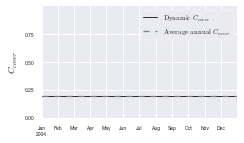

In [33]:
# ADDITIONAL BITS AND PIECES

# Plot dynamic crop factor  
C_crop = df_TC_dict[1]['C_cover_A']
C_crop_av = p_LU['A']['C_cover']

fig = plt.figure(figsize=(3.5, 2.0))
ax = fig.add_subplot(1,1,1)
C_crop.plot(ax=ax, color='k', lw=1, alpha=0.8, label='$\mathrm{Dynamic}\, C_{cover}$')
ax.axhline(C_crop_av, color='0.5', lw=1.3, ls='--', label='$\mathrm{Average\, annual}\, C_{cover}$')
plt.ylabel('$C_{cover}$',fontsize=9)
plt.xlabel('')
plt.ylim(0,1)
ax.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
ax.legend(loc='best', frameon=True, prop={'size':'x-small'})
ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=5)

plt.show()

# Ccov_fname = os.path.join(p_SU.output_fpath, "Fig_dynamic_Ccov.eps")
# plt.savefig(Ccov_fname, bbox_inches='tight', dpi=p_SU.output_fig_dpi)
# plt.close()

In [34]:
fs = np.array([0.25,0.75])
Cs = np.array([10,5])
Ps = np.array([100.,0.])
Pav = (1/np.sum(fs*Cs))*np.sum(fs*Cs*Ps)
Pav


40.0

In [35]:
2*[p_LU.ix['C_cover','A'],p_LU.ix['C_cover','IG'],p_LU.ix['C_cover','S']]

[0.20000000000000001,
 0.089999999999999997,
 0.021000000000000001,
 0.20000000000000001,
 0.089999999999999997,
 0.021000000000000001]